### Imports

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cfeature
from matplotlib.colors import Normalize

In [2]:
climate_ds = xr.open_dataset("data/era5_climate_data/era5-land-yearly-means-sliced.nc")

In [38]:
# --- small utilities -------------------------------------------------------

def _region_extent(ds, margin=0.5):
    lat = ds['latitude'].values
    lon = ds['longitude'].values
    return [float(lon.min())-margin, float(lon.max())+margin,
            float(lat.min())-margin, float(lat.max())+margin]

def _geoaxes(projection=None):
    if projection is None:
        projection = ccrs.PlateCarree()
    fig = plt.figure(figsize=(7.5, 6))
    ax = plt.axes(projection=projection)
    return fig, ax

def _decorate_map(ax, extent, coast_res='50m', add_land=True, add_borders=True, grid=True):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    if add_land:
        ax.add_feature(cfeature.LAND, facecolor='whitesmoke', zorder=0)
        ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=0)
    ax.coastlines(resolution=coast_res, linewidth=0.8)
    if add_borders:
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    if grid:
        gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, linewidth=0.4)
        gl.right_labels = False
        gl.top_labels = False

def _coslat_weights_2d(ds):
    """Return 2-D cosine-latitude weights (latitude, longitude)."""
    w_lat = np.cos(np.deg2rad(ds['latitude']))
    # broadcast to (lat, lon) using any 2D slice
    w2d = w_lat.broadcast_like(ds.isel(year=0, drop=True))
    # normalize (optional)
    return w2d / w2d.mean()

# --- 1) Climatology map (mean over years) ----------------------------------

def plot_climatology_map(clim, var, projection=None, vmin=None, vmax=None, cmap='viridis',
                         as_mm=False, coast_res='50m', title_suffix=' (climatology)'):
    """
    Map of the 1993–2020 (or whatever years you have) mean.
    Set as_mm=True for tp (meters -> millimeters).
    """
    da = clim[var]
    mean_da = da.mean('year', skipna=True)
    if as_mm:
        mean_da = mean_da * 1000.0  # m -> mm
    label = f"{var} ({'mm' if as_mm else mean_da.attrs.get('units','')})".strip()

    fig, ax = _geoaxes(projection)
    _decorate_map(ax, _region_extent(clim), coast_res=coast_res)

    im = mean_da.plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
        vmin=vmin, vmax=vmax,
        cbar_kwargs={'label': label}
    )
    ax.set_title(f"{var}{title_suffix}")
    plt.tight_layout()
    return fig, ax, im

# --- 2) Interannual variability map (std or CV) ----------------------------

def plot_variability_map(clim, var, metric='std', projection=None, cmap='magma',
                         as_mm=False, vmin=None, vmax=None):
    """
    Map interannual variability:
    - metric='std'  : standard deviation across years
    - metric='cv'   : coefficient of variation = std/mean (×100 if as_percent=True)
    """
    da = clim[var]
    std_da = da.std('year', skipna=True)
    if as_mm:
        std_da = std_da * 1000.0

    if metric == 'std':
        to_plot = std_da
        label = f"{var} interannual σ ({'mm' if as_mm else da.attrs.get('units','')})".strip()
        title = f"{var} • Interannual Std"
    elif metric == 'cv':
        mean_da = da.mean('year', skipna=True)
        if as_mm:
            mean_da = mean_da * 1000.0
        to_plot = (std_da / mean_da) * 100.0
        label = "Coefficient of variation (%)"
        title = f"{var} • Interannual CV"
    else:
        raise ValueError("metric must be 'std' or 'cv'")

    fig, ax = _geoaxes(projection)
    _decorate_map(ax, _region_extent(clim))
    im = to_plot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                      vmin=vmin, vmax=vmax,
                      cbar_kwargs={'label': label})
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax, im

# --- 3) Seasonal contrast map (e.g., JJA - DJF) ----------------------------

def plot_season_contrast(clim, var_base, season_pos='JJA', season_neg='DJF',
                         projection=None, cmap='coolwarm', vmin=None, vmax=None,
                         as_mm=False):
    """
    For a base like 't2m' or 'tp', compute mean(season_pos) - mean(season_neg) across years.
    Expects variables named like f'{var_base}_season_JJA'.
    """
    a = clim[f'{var_base}_season_{season_pos}'].mean('year', skipna=True)
    b = clim[f'{var_base}_season_{season_neg}'].mean('year', skipna=True)
    diff = a - b
    if as_mm:
        diff = diff * 1000.0

    fig, ax = _geoaxes(projection)
    _decorate_map(ax, _region_extent(clim))
    im = diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                   vmin=vmin, vmax=vmax,
                   cbar_kwargs={'label': f"{var_base} {season_pos}-{season_neg} ({'mm' if as_mm else ''})".strip()})
    ax.set_title(f"{var_base}: {season_pos} − {season_neg}")
    plt.tight_layout()
    return fig, ax, im

# --- 4) Trend map (slope per decade) ---------------------------------------

def _linear_trend_per_decade(da):
    """
    Return slope per decade using least-squares fit along 'year'.
    Works with NaNs. Returns DataArray with dims (latitude, longitude).
    """
    # center year to reduce collinearity; slope independent of centering though
    years = da['year'].astype(float)
    x = years - years.mean()
    # polyfit along 'year' per-pixel
    coeffs = xr.polyfit(da, dim='year', deg=1, skipna=True)
    slope = coeffs.polyfit_coefficients.sel(degree=1)
    # convert per-year -> per-decade
    return slope * 10.0

def plot_trend_map(clim, var, projection=None, cmap='coolwarm', vmin=None, vmax=None,
                   as_mm=False, annotate_units=True):
    """
    Plot linear trend (slope per decade) for a variable over the available years.
    For tp in meters, set as_mm=True to get mm/decade.
    """
    da = clim[var]
    if as_mm:
        da = da * 1000.0

    slope_dec = _linear_trend_per_decade(da)

    fig, ax = _geoaxes(projection)
    _decorate_map(ax, _region_extent(clim))
    units = ''
    if annotate_units:
        if as_mm:
            units = 'mm/decade'
        else:
            units = da.attrs.get('units', '')
            units = (units + '/decade').strip('/')

    im = slope_dec.plot(ax=ax, transform=ccrs.PlateCarree(),
                        cmap=cmap, vmin=vmin, vmax=vmax,
                        cbar_kwargs={'label': f"Trend ({units})" if units else "Trend"})
    ax.set_title(f"{var} • Linear trend")
    plt.tight_layout()
    return fig, ax, im

# --- 5) Area-weighted regional time series (with seasons) ------------------

def area_mean_series(clim, var):
    """
    Return area-weighted regional mean per year using cos(lat).
    """
    w2d = _coslat_weights_2d(clim)
    num = (clim[var] * w2d).sum(dim=('latitude','longitude'), skipna=True)
    den = w2d.sum(dim=('latitude','longitude'))
    return num / den  # dims: year

def plot_regional_timeseries(clim, vars_or_pairs, as_mm=False, title='Regional mean time series', add_trend=False):
    """
    Plot one or multiple regional time series. vars_or_pairs can be:
      - list of strings (variable names), or
      - list of (var, label) tuples to customize legend labels.
    If add_trend=True, adds a linear trend line for each series.
    """
    plt.figure(figsize=(8.5, 3.6))
    if isinstance(vars_or_pairs[0], (list, tuple)):
        items = vars_or_pairs
    else:
        items = [(v, v) for v in vars_or_pairs]

    for var, label in items:
        series = area_mean_series(clim, var)
        y = series.values * (1000.0 if (as_mm and 'tp' in var) else 1.0)
        years = series['year'].values
        
        plt.plot(years, y, lw=1.5, label=label)
        
        if add_trend:
            # Fit linear trend
            z = np.polyfit(years, y, 1)
            p = np.poly1d(z)
            plt.plot(years, p(years), '--', alpha=0.6, lw=1.2)

    plt.xlabel('Year'); plt.grid(True, alpha=0.3)
    plt.legend(ncol=2)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"{vars_or_pairs} regional_mean_timeseries.png", dpi=300, bbox_inches='tight')

# --- 6) Correlation heatmap of regional means ------------------------------

def correlation_heatmap(clim, varnames, as_mm_vars=('tp_yearly',), title='Correlation of regional means'):
    """
    Compute area-weighted regional means for each variable (across years),
    then plot a correlation heatmap.
    """
    import matplotlib.ticker as mticker

    # build matrix (years x variables)
    cols = []
    for v in varnames:
        s = area_mean_series(clim, v)
        y = s.values * (1000.0 if v in as_mm_vars else 1.0)
        cols.append(y)
    M = np.vstack(cols).T  # (years, vars)
    C = np.corrcoef(M, rowvar=False)

    fig, ax = plt.subplots(figsize=(1.2*len(varnames), 0.9*len(varnames)))
    im = ax.imshow(C, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_xticks(range(len(varnames))); ax.set_yticks(range(len(varnames)))
    ax.set_xticklabels(varnames, rotation=45, ha='right')
    ax.set_yticklabels(varnames)
    plt.title(title)
    cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    cb = fig.colorbar(im, cax=cax, label='Pearson r')
    plt.subplots_adjust(right=0.88)
    return fig, ax, im

# --- 7) Hovmöller-style latitude-year heatmap ------------------------------

def hovmoller_lat_year(clim, var, season=None, cmap='viridis', as_mm=False, vmin=None, vmax=None):
    """
    Zonal (longitude-mean) Hovmöller: latitude vs year.
    If 'season' is given (e.g., 'JJA'), expects f'{var}_season_{season}'.
    """
    if season is not None:
        varname = f'{var}_season_{season}'
    else:
        varname = var

    da = clim[varname]
    if as_mm:
        da = da * 1000.0

    # area-weighted zonal mean (weight by cos(lat) along longitude? optional)
    # Here we do a plain zonal mean (mean over longitude)
    zonal = da.mean('longitude', skipna=True)  # dims: year, latitude

    plt.figure(figsize=(8, 4.2))
    im = zonal.T.plot(x='year', y='latitude', cmap=cmap, vmin=vmin, vmax=vmax,
                      cbar_kwargs={'label': f"{varname} ({'mm' if as_mm else da.attrs.get('units','')})".strip()})
    plt.title(f"{varname} • Zonal mean (lon-avg)")
    plt.xlabel('Year'); plt.ylabel('Latitude')
    plt.tight_layout()
    plt.savefig(f"hovmoller_{varname}.png", dpi=200)
    return im


In [10]:
def to_celsius(ds, explicit_vars=('t2m', 'stl1', 'stl4')):
    """
    Convert Kelvin → Celsius for temperature variables in a dataset that includes
    yearly/seasonal variables like 't2m_yearly', 't2m_season_JJA', etc.

    Rules:
      1) Any var whose name starts with any of `explicit_vars` gets converted.
      2) Any var with attrs['units'] in {'K','kelvin','Kelvin'} gets converted.
      3) Skip variables already in °C (units contain 'c'/'°C' or attr flag set).
    """
    ds = ds.copy()

    def _is_temp_var(name, da):
        # name-based rule
        if any(name.startswith(v) for v in explicit_vars):
            return True
        # units-based rule
        u = str(da.attrs.get('units', '')).lower()
        if u in {'k', 'kelvin'}:
            return True
        return False

    for name, da in ds.data_vars.items():
        if not _is_temp_var(name, da):
            continue
        # already Celsius?
        u = str(da.attrs.get('units', '')).lower()
        if ('c' in u) or da.attrs.get('_units_converted_to') == 'C':
            continue

        # convert
        ds[name] = da - 273.15

        # tidy attrs
        new = ds[name]
        # update units
        new.attrs['units'] = '°C'
        # be explicit in long_name if present
        ln = new.attrs.get('long_name', '') or name
        if 'kelvin' in ln.lower() or '(k' in ln.lower():
            ln = ln.replace('Kelvin', 'Celsius').replace('kelvin', 'Celsius')
        new.attrs['long_name'] = ln if 'Celsius' in ln else f'{ln} (Celsius)'
        # mark to prevent re-conversion
        new.attrs['_units_converted_to'] = 'C'

    return ds


In [11]:
climate_ds_c = to_celsius(climate_ds)

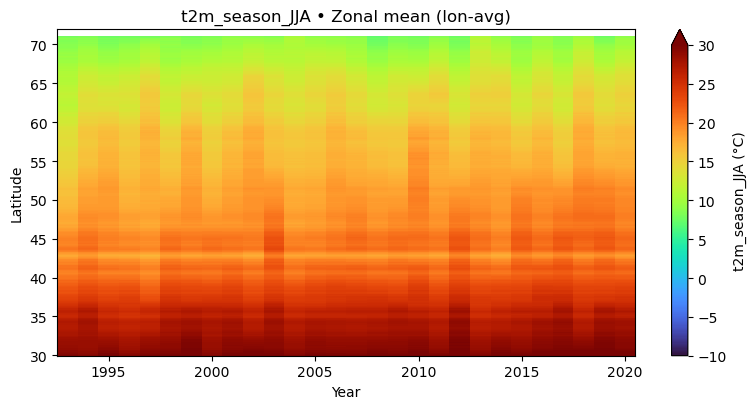

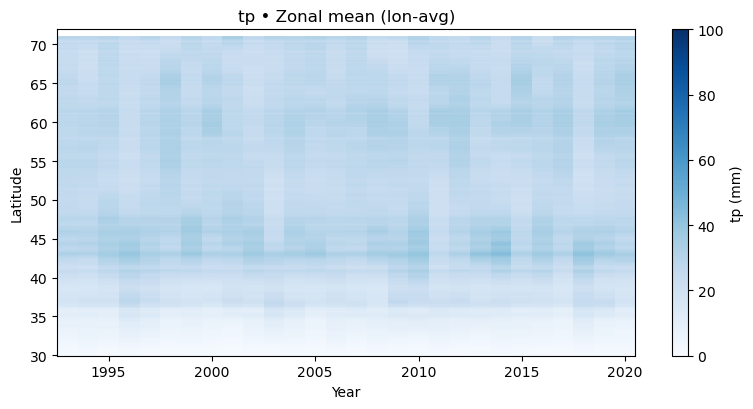

In [33]:
hovmoller_lat_year(climate_ds_c, 't2m', season='JJA', cmap='turbo', vmin=-10, vmax=30)
hovmoller_lat_year(climate_ds_c, 'tp',  season=None,   cmap='Blues', as_mm=True, vmin=0, vmax=100)


(<Figure size 360x270 with 2 Axes>,
 <Axes: title={'center': 'Correlation of regional means'}>,
 <matplotlib.image.AxesImage at 0x7f9ffa811be0>)

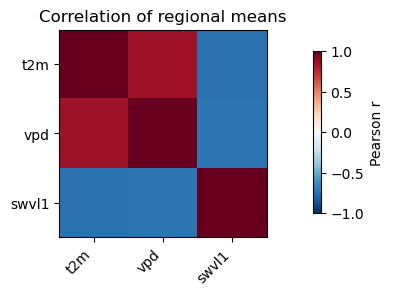

In [21]:
corr_vars = ['t2m','vpd','swvl1']
correlation_heatmap(climate_ds_c, corr_vars)

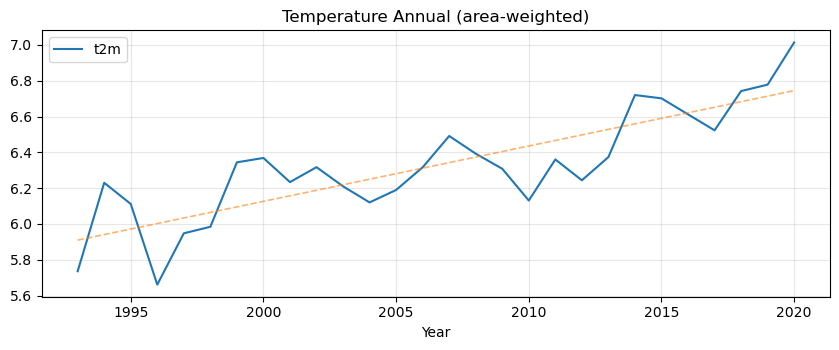

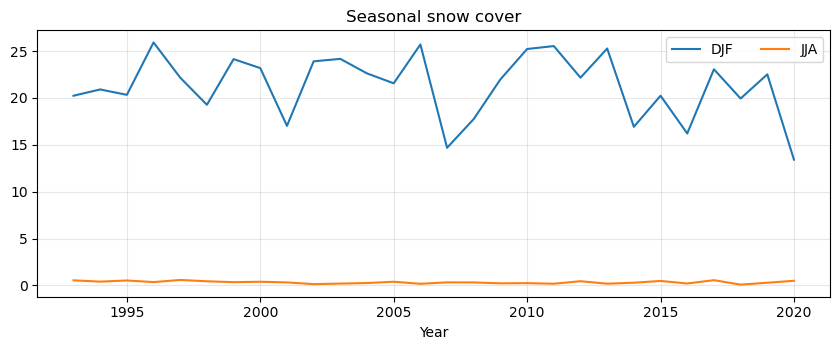

In [41]:
plot_regional_timeseries(climate_ds_c, ['t2m'], title='Temperature Annual (area-weighted)', add_trend=True)
plot_regional_timeseries(climate_ds_c, [('snowc_season_DJF','DJF'), ('snowc_season_JJA','JJA')], title='Seasonal snow cover', as_mm=False)


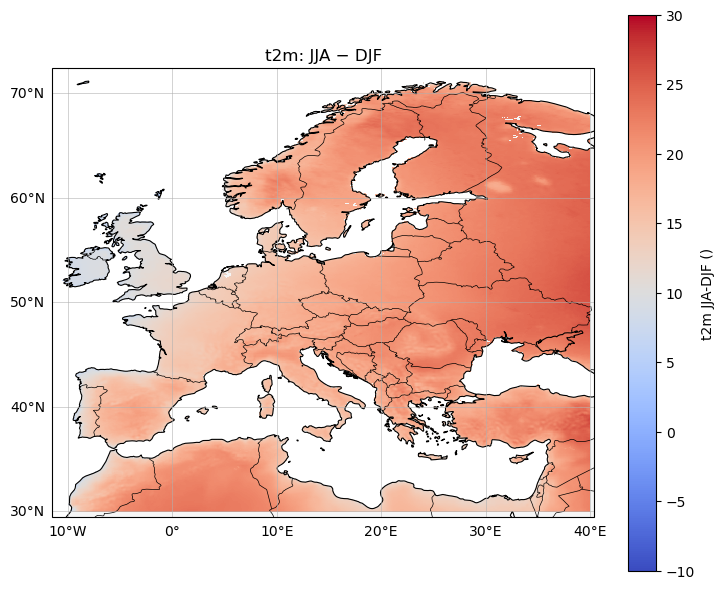

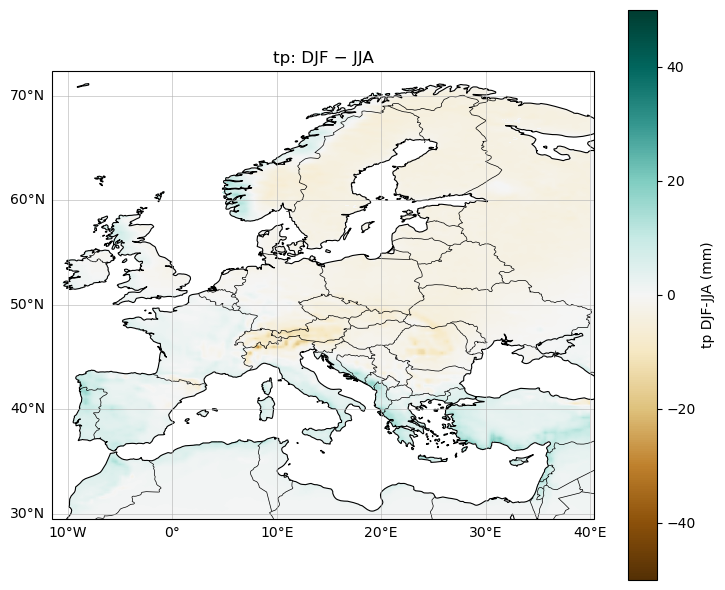

In [35]:
fig, x, y = plot_season_contrast(climate_ds_c, 't2m', season_pos='JJA', season_neg='DJF', cmap='coolwarm', vmin=-10, vmax=30)
fig.savefig("t2m_season_contrast_JJA_DJF.png", dpi=300, bbox_inches='tight')

fig, x, y = plot_season_contrast(climate_ds_c, 'tp',  season_pos='DJF', season_neg='JJA', cmap='BrBG', as_mm=True, vmin=-50, vmax=50)
fig.savefig("tp_season_contrast_JJA_DJF.png", dpi=300, bbox_inches='tight')


(<Figure size 750x600 with 2 Axes>,
 <GeoAxes: title={'center': 'tp • Interannual CV'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f9ffa26b610>)

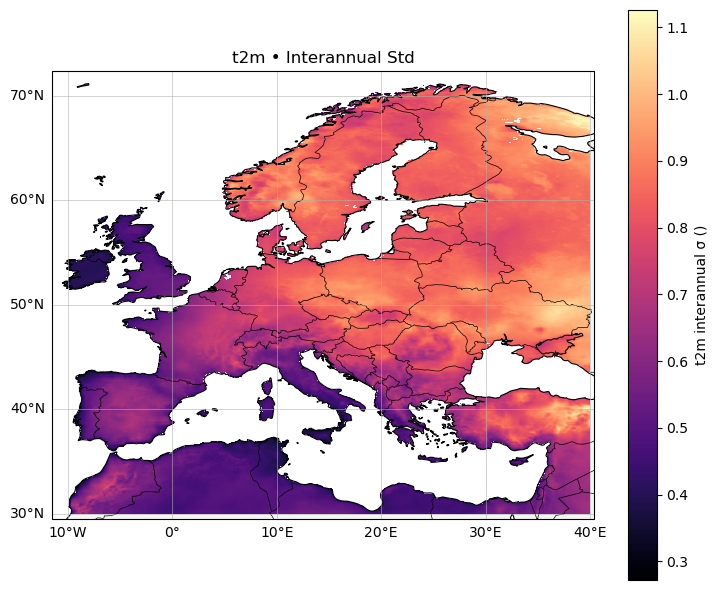

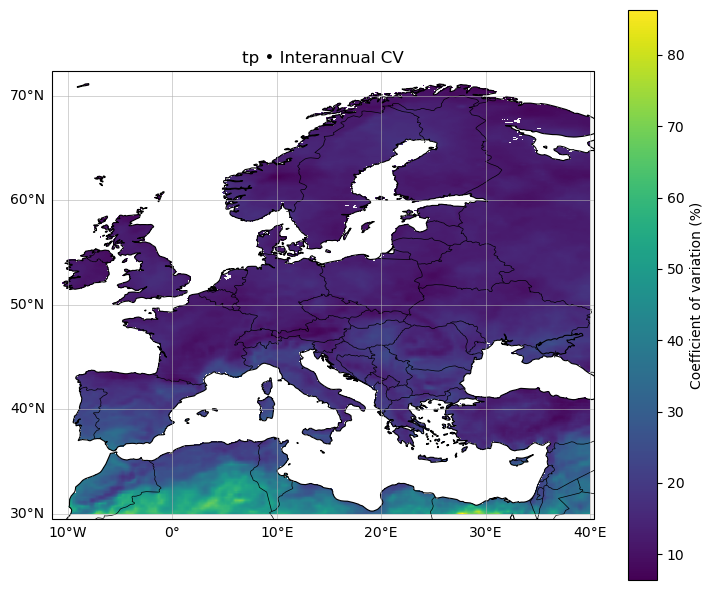

In [8]:
plot_variability_map(climate_ds, 't2m', metric='std', cmap='magma')
plot_variability_map(climate_ds, 'tp',  metric='cv',  cmap='viridis', as_mm=True)

(<Figure size 750x600 with 2 Axes>,
 <GeoAxes: title={'center': 'tp (climatology)'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f9ff9cdd590>)

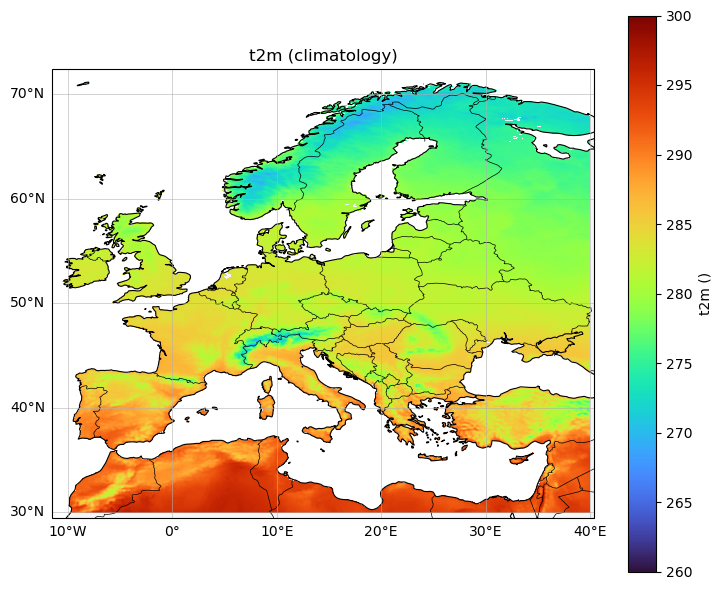

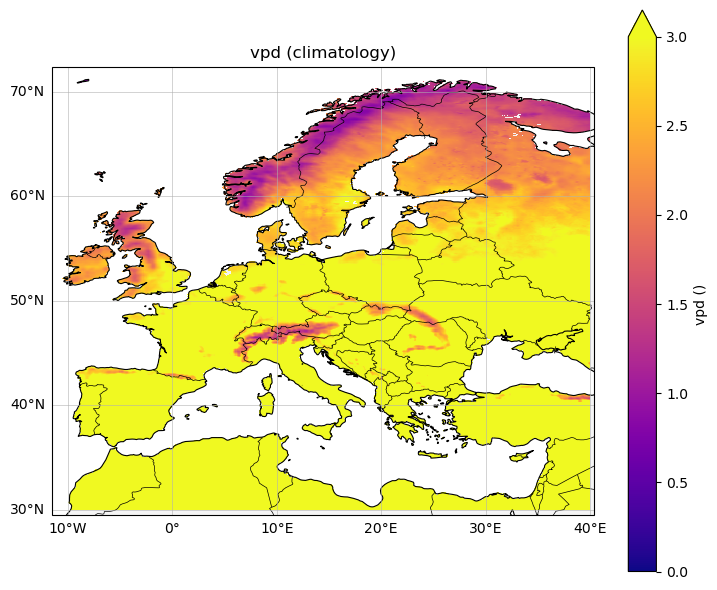

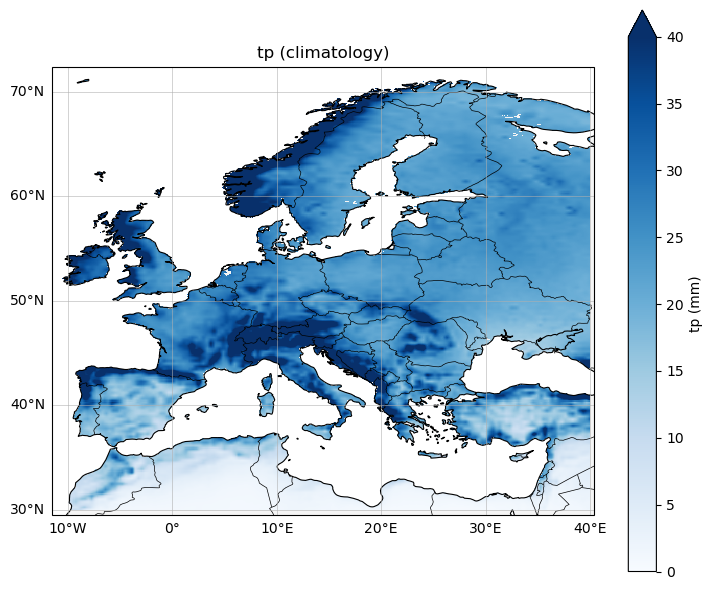

In [7]:
# 1) Climatology maps
plot_climatology_map(climate_ds, 't2m', vmin=260, vmax=300, cmap='turbo')
plot_climatology_map(climate_ds, 'vpd', vmin=0, vmax=3, cmap='plasma')
plot_climatology_map(climate_ds, 'tp',  vmin=0, vmax=40, cmap='Blues', as_mm=True)